In [1]:
# install useful packages
#pip install yfinance --upgrade --no-cache-dir
#pip install pandas_datareader

In [2]:
# to see what in the package
#help(yf)

In [3]:
#pip install get-all-tickers

# Import Packages

In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [5]:
import pandas_datareader.data as pdweb
from pandas_datareader import data as pdr
import yfinance as yf # must pip install first 

In [6]:
## models
#from arch import arch_model
from sklearn.model_selection import TimeSeriesSplit
import sys
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from dateutil.parser import parse 
import datetime
pd.set_option("display.max_rows", 5000)

## Import Datasets: the benchmark(S&P500) and choices from users

## (1) The Benchmark Dataset: overall trend and daily return

In [7]:
data_spy = pdr.get_data_yahoo("SPY", start="2017-01-01", end='2021-03-25')

In [8]:
spy_close = data_spy['Close']
spy_close = spy_close.asfreq('D', method='pad')

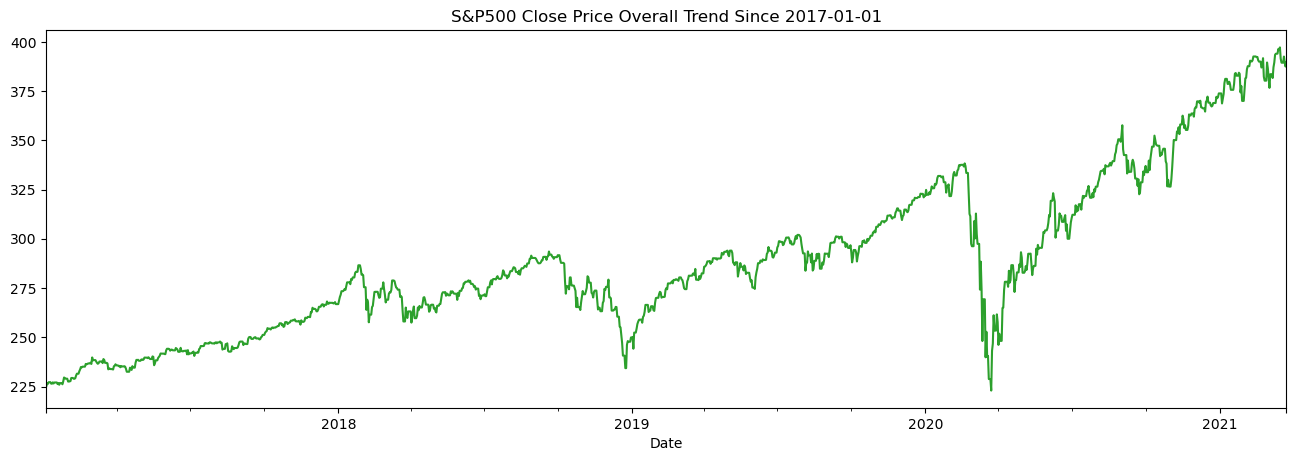

In [9]:
# the overall trend for benchmark from 2017-01-01
plt.figure(figsize=(16,5), dpi=100)
plt.title('S&P500 Close Price Overall Trend Since 2017-01-01')
spy_close.plot(color='tab:green')
plt.savefig('benchmark.png')

## Remarks: The picture shows the overall trend of the stock market. In general, there is an increasing trendency with some fluctuation. Users can decide to buy-in at low points such as Jan 2019 and March 2020. 

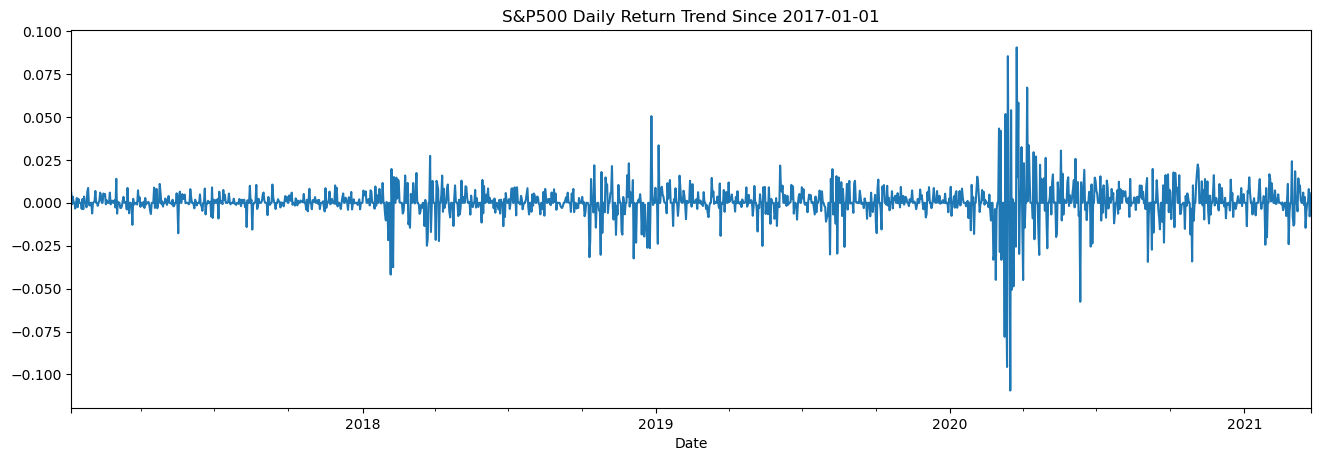

In [18]:
# plot the daily return for benchmark from 2017-01-01
plt.figure(figsize=(16,5), dpi=100)
plt.title('S&P500 Daily Return Trend Since 2017-01-01')
benchmark_ret = spy_close.pct_change()[1:]
benchmark_ret.plot()
plt.savefig('benchmark_return.png')

# Remarks: $Daily Return = \frac{Current Day Closed Price - Previous Day Closed Price}{Previous Day Closed Price} * 100 \% $. The daily return measures the dollar change in a stock's price as a percentage of the previous day's closing price. It reflects how fluatuated the prices change daily. From the picture, the daily returns from 2017-01-01 to 2020-01-01 do not fluctuate much and stay stable. The returns change much and fluctuate heavily during March 2020 due to COVID-19. 

In [11]:
spy_close_r = spy_close.resample('W-Mon').mean()
spy_close_r.head()

Date
2017-01-09    226.615718
2017-01-16    226.898575
2017-01-23    226.468573
2017-01-30    228.708575
2017-02-06    228.552854
Freq: W-MON, Name: Close, dtype: float64

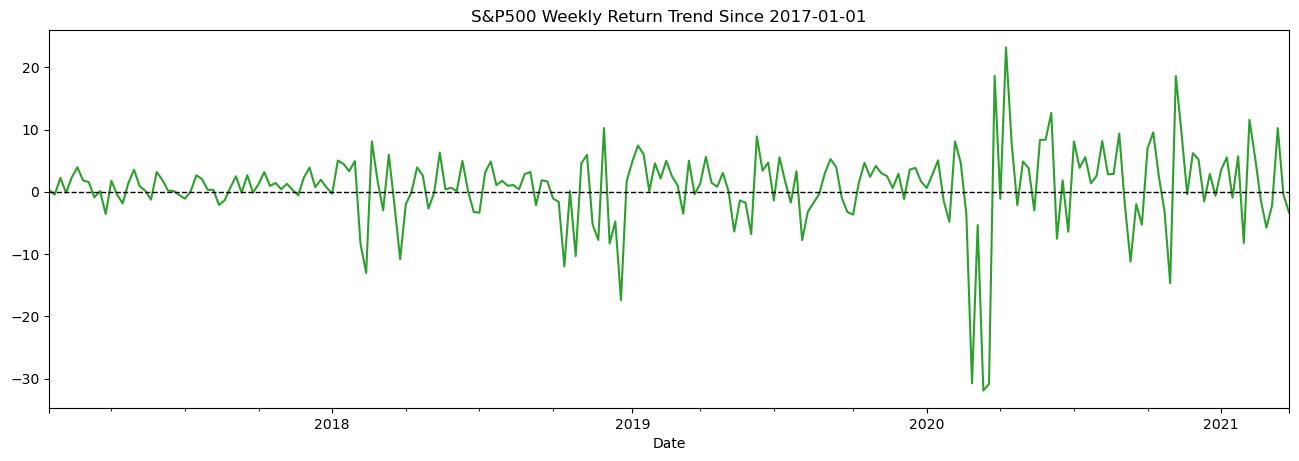

In [12]:
plt.figure(figsize=(16,5), dpi=100)
diff_spy = spy_close_r.diff().dropna()
diff_spy.plot(color='tab:green')
plt.title('S&P500 Weekly Return Trend Since 2017-01-01')
plt.axhline(y=0,linewidth=1, color='black',linestyle='--')

## (2) The Sticks from Users' Choices (should be accessed from the main website page)

In [19]:
## create a list of tickers and weights based on users' choice
benchmark = ['SPY']
tickers = ['BND', 'VB', 'VEA', 'VOO', 'VWO']
wts = [0.1,0.2,0.25,0.25,0.2]

In [20]:
## draw sample data including both benchmark and users' choice
price_data = pdr.get_data_yahoo(tickers + benchmark, start = '2017-01-01', end='2021-03-25')['Close']

In [21]:
price_data.head()

Symbols,BND,VB,VEA,VOO,VWO,SPY
Date,,,,,,
2017-01-03,80.800003,129.710007,36.770000,206.740005,36.169998,225.240005
2017-01-04,80.860001,131.880005,37.220001,207.960007,36.500000,226.580002
2017-01-05,81.269997,130.830002,37.549999,207.800003,36.880001,226.399994
2017-01-06,80.949997,130.649994,37.400002,208.610001,36.730000,227.210007
2017-01-09,81.150002,129.869995,37.310001,207.949997,36.669998,226.460007


In [22]:
# Calculate the daily return for each stick chosen
ret_data = price_data.pct_change()[1:]
len(ret_data)
ret_data[tickers].head()

Symbols,BND,VB,VEA,VOO,VWO
Date,,,,,
2017-01-04,0.000743,0.016730,0.012238,0.005901,0.009124
2017-01-05,0.005070,-0.007962,0.008866,-0.000769,0.010411
2017-01-06,-0.003937,-0.001376,-0.003995,0.003898,-0.004067
2017-01-09,0.002471,-0.005970,-0.002406,-0.003164,-0.001634
2017-01-10,-0.000247,0.007315,0.001072,-0.000144,0.005454


In [25]:
# Calculate the daily return for the whole portfolio chosen by users
port_ret = (ret_data[tickers] * wts).sum(axis = 1)
benchmark_ret = ret_data[benchmark]
#port_ret[:20]
#type(port_ret) #pandas.core.series.Series
#type(ret_data)
#type(benchmark_ret) #pandas.core.frame.DataFrame

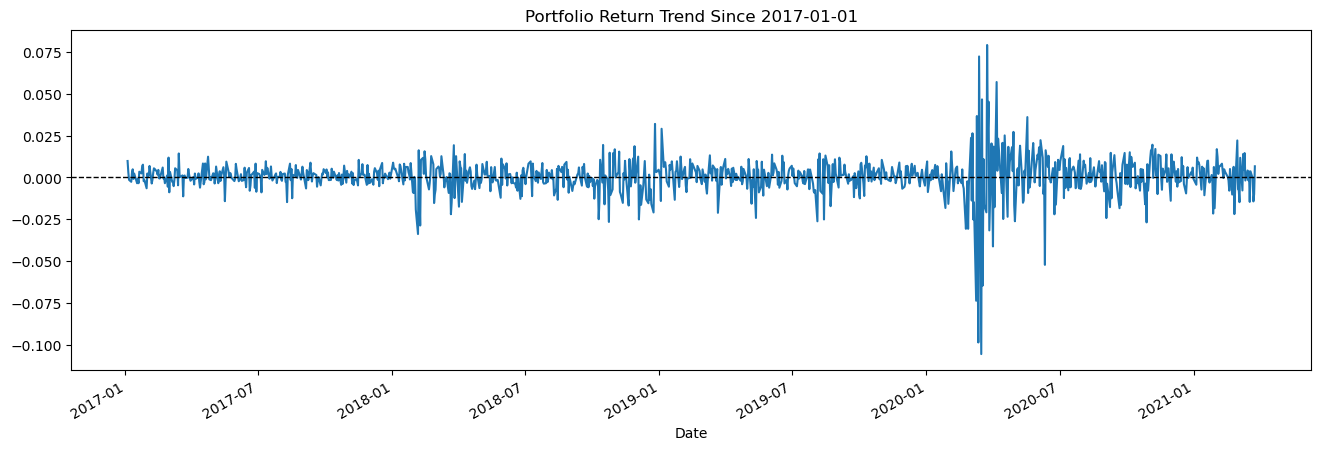

In [27]:
plt.figure(figsize=(16,5), dpi=100)
port_ret.plot()
plt.title('Portfolio Return Trend Since 2017-01-01')
plt.axhline(y=0,linewidth=1, color='black',linestyle='--')
plt.savefig('portfolio_return.png')

## (3) Market-Beta 
Beta coefficient(β)= $\frac{Covariance(R_e, R_m)}{Variance(R_m)}$ 

$R_e$=the return on an individual stock 

$R_m$=the return on the overall market 

Covariance=how changes in a stock’s returns are related to changes in the market’s returns 

Variance=how far the market’s data points spread out from their average value 

In [28]:
# reshape the data to be used in regression model
benchmark_ret = benchmark_ret.values.reshape(-1)

C:\Users\13193\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


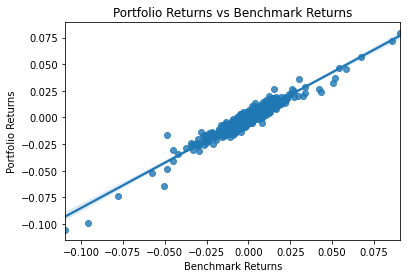

In [29]:
sns.regplot(benchmark_ret, port_ret.values)
plt.xlabel("Benchmark Returns")
plt.ylabel("Portfolio Returns")
plt.title("Portfolio Returns vs Benchmark Returns")
plt.savefig('regression.png')
plt.show()

## The beta calculation is used to help investors understand whether a stock moves in the same direction as the rest of the market. The beta value is 0.85 which is less than 1.0 and means that the security is theoretically less volatile than the market. If users expect to gain more return, they can either adjust the weights of their portfolio or add some sticks with higher return with more volatile and higher risk. 

In [30]:
(beta, alpha) = stats.linregress(benchmark_ret, port_ret.values)[0:2]
print("The portfolio beta is", round(beta, 4))

The portfolio beta is 0.85
